In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from gurobipy import *

In [3]:
NET_SIZE = 12

# FACILITY
CANDIDATES = [(3*x, 3*y) for x in range(5) for y in range(5)]
J = len(CANDIDATES)

# CAR TYPE
K = 2
V = [[random.randint(1, 10) for k in range(K)] for j in range(J)]

# COMPETITORS
COMPETITORS = [(4, 4), (4, 8), (8, 4), (8, 8)]
L = len(COMPETITORS)

A_c = [random.randint(10, 100) for x in range(L)]


# CONSUMERS
I = 3
CONSUMERS = []
while(len(CONSUMERS) != I):
    temp_new_cons = (random.randint(0, NET_SIZE), random.randint(0, NET_SIZE))
    if temp_new_cons not in COMPETITORS and temp_new_cons not in CANDIDATES:
        CONSUMERS.append(temp_new_cons)

H = [random.randint(100, 1000) for x in range(I)]

# DISTANCE
D = []
for x_i, y_i in CONSUMERS:
    temp = []
    for x_j, y_j in CANDIDATES:
        temp.append(((x_i - x_j)**2 + (y_i - y_j)**2)**(1/2))
    D.append(temp)

D_c = []
for x_i, y_i in CONSUMERS:
    temp = []
    for x_l, y_l in COMPETITORS:
        temp.append(((x_i - x_l)**2 + (y_i - y_l)**2)**(1/2))
    D_c.append(temp)

# COST
F = [random.randint(3, 30) for x in range(J)]
C = [random.randint(1, 3) for x in range(J)]
B = [[random.randint(3, 5) for k in range(K)] for j in range(J)]

# BOUND
U_LT = [[random.randint(5, 10) for k in range(K)] for j in range(J)]
U_T = [random.randint(50, 100) for x in range(K)]
U_L = [random.randint(1, 20) for x in range(J)]

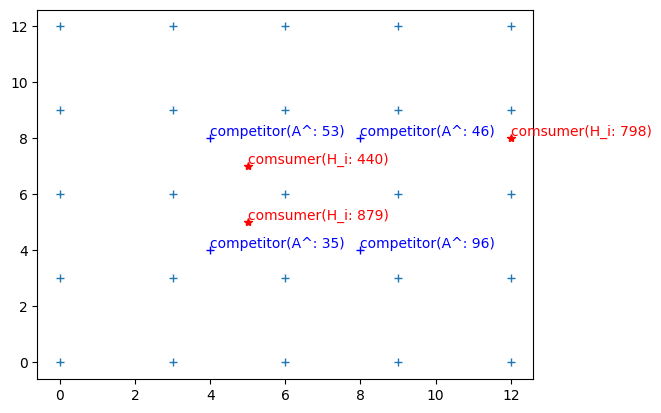

In [4]:
plt.plot([x[0] for x in CONSUMERS], [x[1] for x in CONSUMERS], 'r*')
for i in range(I):
    plt.text(CONSUMERS[i][0], CONSUMERS[i][1]+0.1, 'comsumer(H_i: ' + str(H[i]) + ')', color='r')
plt.plot([x[0] for x in COMPETITORS], [x[1] for x in COMPETITORS], 'b+')
for l in range(L):
    plt.text(COMPETITORS[l][0], COMPETITORS[l][1]+0.1, 'competitor(A^: ' + str(A_c[l]) + ')', color='b')
plt.plot([x[0] for x in CANDIDATES], [x[1] for x in CANDIDATES], '+')
# plt.axis([-1, 13, -1, 13])

In [5]:
def LR_alg_1(lambda_n, mu_n, rho_n, sigma_n):
    
    Y = [-1 for x in range(J)]
    sum_lambda_U_LT_list = []

    for j in range(J):
        
        sum_lambda_U_LT = 0
        for k in range(K):
            sum_lambda_U_LT = sum_lambda_U_LT + lambda_n[j][k]*U_LT[j][k]
        sum_lambda_U_LT_list.append(sum_lambda_U_LT)

        if -F[j] + sum_lambda_U_LT + sigma_n[j] >= 0:
            Y[j] = 1
        else:
            Y[j] = 0

    #GUROBI

    m = Model("LR_alg_1")

    ## Create variables
    X = []
    for j in range(J):
        temp = []
        for k in range(K):
            temp.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="X_" + str(j) + '_' + str(k)))
        X.append(temp)

    A_EX = []
    for j in range(J):
        A_EX.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="A^X_" + str(j)))

    TA = []
    for i in range(I):
        TA.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="TA_" + str(i)))

    W = []
    for i in range(I):
        W.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="W_" + str(i)))

    u = []
    for i in range(I):
        temp = []
        for j in range(J):
            temp.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="u_" + str(i) + '_' + str(j)))
        u.append(temp)

    p = []
    for i in range(I):
        p.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="p_" + str(i)))



    ## Integrate new variables
    m.update()

    ## Set objective
    m.setObjective(quicksum(W[i] for i in range(I)) \
                 + quicksum(-F[j] + sum_lambda_U_LT_list[j] + sigma_n[j] for j in range(J))*Y[j] \
                 + quicksum((-C[j] - sigma_n[j])*A_EX[j] for j in range(J)) \
                 + quicksum((-B[j][k] - lambda_n[j][k] - mu_n[j] - rho_n[k])*X[j][k] for j in range(J) for k in range(K)) \
                 + quicksum(mu_n[j]*U_L[j] for j in range(J)) + quicksum(rho_n[k]*U_T[k] for k in range(K)), GRB.MAXIMIZE)

    ## Add constraints:
    ### E(x) = 1/5
    ### G(x) = 1/2
    for i in range(I):
        for j in range(J):
            m.addConstr(u[i][j] == quicksum((V[j][k]*X[j][k] + A_EX[j])/D[i][j]**2 for k in range(K)), 'define_u_ij_' + str(i) + '_' + str(j))
    
    for i in range(I):
        m.addConstr(TA[i] == quicksum(u[i][j] for j in range(J)) + quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), "define_TA_i_" + str(i))
    
    for i in range(I):
        m.addConstr(quicksum(u[i][j] for j in range(J)) == p[i] * TA[i] , 'define_p_i_' + str(i))
    
    for i in range(I):
        m.addConstr(W[i] == H[i]*(1/2)*TA[i] * p[i], 'define_W_i_' + str(i))

    
    m.optimize()

    print('\n##################\nObj: %g \n##################\n' % m.objVal)
    

    return Y




In [6]:
lambda_list = [[[1 for k in range(K)] for j in range(J)]]
mu_list = [[1 for j in range(J)]]
rho_list = [[1 for k in range(K)]]
sigma_list = [[1 for j in range(J)]]

LR_alg_1(lambda_list[0], mu_list[0], rho_list[0], sigma_list[0])

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-22
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.5.0 21F79)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 78 rows, 159 columns and 378 nonzeros
Model fingerprint: 0xa3a9e56c
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 4e+02]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 4e+01]
Presolve removed 0 rows and 50 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 72 rows and 125 columns
Presolve time: 0.00s
Presolved: 18 rows, 35 columns, 108 nonzeros
Presolved model has 3 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller bounds for these var

[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1]

In [ ]:
# lambda_list = [[100000 for i in range(NUM_I)]]
# L_lambda_list = []
# X_list = []
# Y_list = []

# DELTA = 10
# EPSILON = 0.01
# MAX_ITERATION = 100

# lambda_n = lambda_list[0]
# for i in range(MAX_ITERATION):
#     X, Y, L_lambda = UFL_L_Lambda(lambda_n)
#     X_list.append(X)
#     Y_list.append(Y)
#     L_lambda_list.append(L_lambda)
    
#     if len(L_lambda_list) >=2:
#         improve = (L_lambda_list[-1] - L_lambda_list[-2])/abs(L_lambda_list[-2])
#         if  improve >= 0 and improve < EPSILON:
#             print('X:')
#             display(X)
#             print('Y:')
#             display(Y)
#             print('L_lambda:', L_lambda)
#             print('iteration:', i+1)
#             break

#     lambda_np = [lambda_n[x] + DELTA*(1 - sum(Y[x])) for x in range(NUM_I)] 
#     lambda_list.append(lambda_np)
#     lambda_n = lambda_np
    

In [ ]:
lambda_list